<a href="https://colab.research.google.com/github/JGagacheva/FlowerClassifier/blob/main/Flower_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

API to import data from Kaggle onto Google colab. I downloaded the files locally, so i'll be using that instead. 

In [ ]:
# # upload the kaggle.json API file downloaded from kaggle
# from google.colab import files
# files.upload()

In [ ]:
# # install the kaggle API client
# !pip install -q kaggle

# # make a separate directory for the kaggle api
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle

# # make directory private
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# # Copy the stackoverflow data set locally.
# !kaggle competitions download tpu-getting-started -p /content/drive/MyDrive/ColabNotebooks

In [ ]:
# !unzip /content/drive/MyDrive/ColabNotebooks/tpu-getting-started.zip

#Kaggle & TensorFlow tutorial #

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import PIL

In [ ]:
# check tensorflow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


## Load data

In [ ]:
# load dataset from tensorflow drive
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin = dataset_url, untar = True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 3s 0us/step


In [ ]:
# get the sub-directories in the dataset flower_photos
list(data_dir.glob("*"))

[PosixPath('/root/.keras/datasets/flower_photos/daisy'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/sunflowers')]

In [ ]:
# get the count of data
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


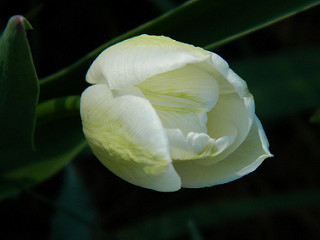

In [ ]:
tulips = list(data_dir.glob("tulips/*"))
#PIL stands for Python Imaging Library and enables us to look at image files in Pyhton.
PIL.Image.open(str(tulips[20])) 

## Create a dataset from the loaded data

In [ ]:
# define parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# split the data into training and validation set
train = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split = 0.2,
    subset = "training",
    seed = 123, 
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

validation = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123, 
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# get the class name for the datasets; cleaner than the above path.glob
class_names = train.class_names

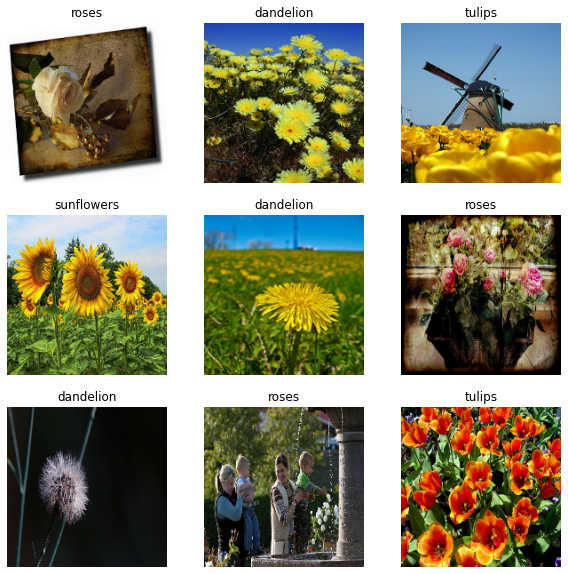

In [ ]:
# visualize the data
plt.figure(figsize = (10, 10))
for images, labels in train.take(1): #creates a dataset with at most count elements from this dataset. 
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) #astype is a numpy method so we have to include it. 
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Use buffered prefetching to load data from disk, so that the I/O does not become clogged. In the essence, best performance is achieved by an efficient input pipeline that delivers data for the next step before the current step has finished. Two important methods for loading data are:
- `Dataset.cache` keeps the data on memory after offloading from disk during the first epoch. If the dataset is too large to fit on memory, you can also create a performant on-disk cache. This method ensures that the dataset does not become a bottleneck in the training process. 

- `Dataset.prefetch` overlaps preprocessing and model execution during training. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested.

Read more at the [tf.data API guide](https://www.tensorflow.org/tutorials/images/classification). 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().prefetch(buffer_size = AUTOTUNE)

## Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

# A basic Keras model

## Create the model

A Sequential model is appropriate for a plain stack of layers where **each layer has exactly one input tensor and one output tensor**.

A Sequential model is not appropriate when:

- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)

In [ ]:
num_classes = len(class_names)

model = keras.Sequential([
    # input + standardization layer 
    layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),

    # base layers for filtering and detection
    layers.Conv2D(16, 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),

    # head layers
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dense(num_classes)
])

In [ ]:
# view all the layers of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Compile the model

To compile the model, define an optimizer and a loss function. To view the training and validation accuracy for each training epoch, pass the metrics argument to `Model.compile`.

In [ ]:
model.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              metrics = ["accuracy"]
)

## Train the model

In [ ]:
fitted = model.fit(train, 
                   validation_data = validation,
                   epochs = 10
                   )

Epoch 1/10
92/92 [==============================] - 101s 1s/step - loss: 1.4054 - accuracy: 0.3965 - val_loss: 1.1361 - val_accuracy: 0.5409
Epoch 2/10
92/92 [==============================] - 91s 988ms/step - loss: 1.0356 - accuracy: 0.5794 - val_loss: 1.0055 - val_accuracy: 0.6158
Epoch 3/10
92/92 [==============================] - 92s 999ms/step - loss: 0.8287 - accuracy: 0.6890 - val_loss: 0.9401 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 90s 981ms/step - loss: 0.6334 - accuracy: 0.7674 - val_loss: 1.0036 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 90s 980ms/step - loss: 0.4357 - accuracy: 0.8460 - val_loss: 1.0889 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 91s 986ms/step - loss: 0.2584 - accuracy: 0.9169 - val_loss: 1.3150 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 91s 987ms/step - loss: 0.1726 - accuracy: 0.9441 - val_loss: 1.4207 - val_accuracy: 0.6308
E

## Visualize the training results

accuracy        0.976158
val_accuracy    0.653951
dtype: float64

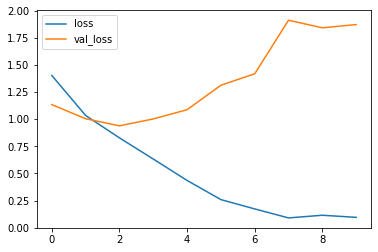

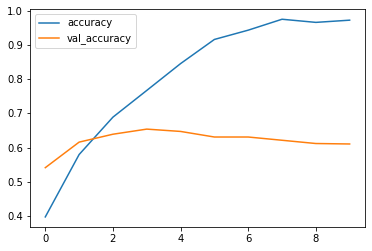

In [ ]:
fitted_history = pd.DataFrame(fitted.history)
fitted_history.loc[:, ["loss", "val_loss"]].plot();
fitted_history.loc[:, ["accuracy", "val_accuracy"]].plot();
fitted_history.loc[:, ["accuracy", "val_accuracy"]].max()

Conclusion from fitted model: the model is overfitted because the validation loss decreases and starts increasing again after the second epoch. 

## Fix overfitting

In [ ]:
# define the data augmentation layer
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

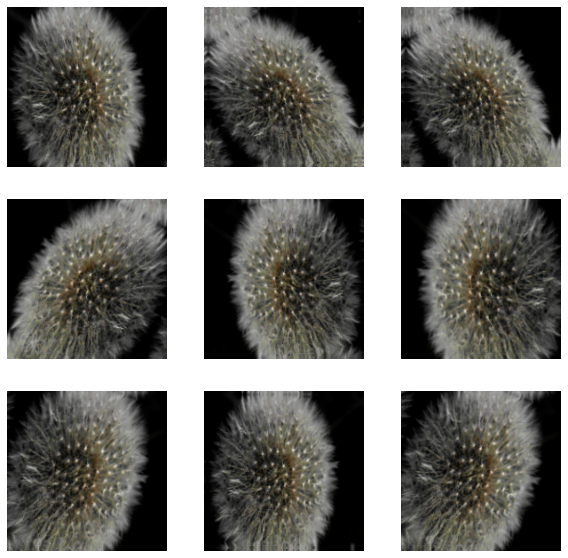

In [ ]:
# visualize augmentation on a few examples

# to visualize an image, we always have to represent it as a figure. 
plt.figure(figsize = (10, 10))
for images, _ in train.take(1):
  for i in range(9):
    augmented_images = augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# add an early stop
from tensorflow.keras import callbacks 
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001, 
    patience = 5,
    restore_best_weights = True
)

In [ ]:
# dropout regulzation layer
model = keras.Sequential([
    # data augmentation layer
    augmentation,

    # standardization layer
    layers.Rescaling(1./255),

    # body 
    layers.Conv2D(16, 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),

    #head
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dense(num_classes, name = "outputs")
])


In [ ]:
# compile the model
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

In [ ]:
fitted = model.fit(
    train, 
    validation_data = validation, 
    epochs = 15,
    callbacks = [early_stopping]
)

Epoch 1/15
92/92 [==============================] - 109s 1s/step - loss: 1.4199 - accuracy: 0.3774 - val_loss: 1.1818 - val_accuracy: 0.5477
Epoch 2/15
92/92 [==============================] - 106s 1s/step - loss: 1.1219 - accuracy: 0.5484 - val_loss: 1.0980 - val_accuracy: 0.5790
Epoch 3/15
92/92 [==============================] - 105s 1s/step - loss: 0.9833 - accuracy: 0.6233 - val_loss: 0.9754 - val_accuracy: 0.6117
Epoch 4/15
92/92 [==============================] - 104s 1s/step - loss: 0.9120 - accuracy: 0.6482 - val_loss: 0.9496 - val_accuracy: 0.6294
Epoch 5/15
92/92 [==============================] - 106s 1s/step - loss: 0.8615 - accuracy: 0.6676 - val_loss: 0.8396 - val_accuracy: 0.6649
Epoch 6/15
92/92 [==============================] - 106s 1s/step - loss: 0.8025 - accuracy: 0.6904 - val_loss: 0.8757 - val_accuracy: 0.6594
Epoch 7/15
92/92 [==============================] - 105s 1s/step - loss: 0.7708 - accuracy: 0.7119 - val_loss: 0.9413 - val_accuracy: 0.6567
Epoch 8/15
92

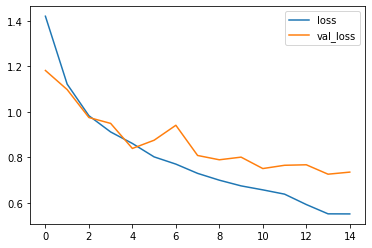

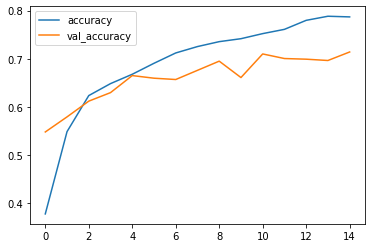

In [ ]:
history_updated = pd.DataFrame(fitted.history)
history_updated.loc[:, ["loss", "val_loss"]].plot();
history_updated.loc[:, ["accuracy", "val_accuracy"]].plot();